In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tensorflow as tf

sys.path.append('../')
from libs.datasets import MNIST
from libs import utils
from tensorflow.python.framework.ops import reset_default_graph

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]
plt.style.use('ggplot')

In [2]:
ds = MNIST(split=[0.8, 0.1, 0.1])

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
reset_default_graph()
n_input = 28 * 28 # image size
n_output = 10     # number of digit classes
X = tf.placeholder(tf.float32, [None, n_input])
Y = tf.placeholder(tf.float32, [None, n_output])

In [4]:
# -1 in reshape indicates dimension should not change size
X_tensor = tf.reshape(X, [-1, 28, 28, 1]) # batch size, h, w, c

In [5]:
filter_size = 5     # = 5 x 5 px
n_filters_in = 1    # corresponds to 1 in X_tensor (no. image channels)
n_filters_out = 32  # e.g., 32 channels of output information

* Take each 28 x 28 image
* Convolve with a 5 x 5 x 32-channel filter w strides of 2 x 2 ->
* Outputs a 14 x 14 x 32-channel tensor

In [6]:
W1 = tf.get_variable(
    name='W1',
    shape=[filter_size, filter_size, n_filters_in, n_filters_out],
    initializer=tf.random_normal_initializer())

b1 = tf.get_variable(name='b1', 
                     shape=[n_filters_out], 
                     initializer=tf.constant_initializer())

h1 = tf.nn.relu(tf.nn.bias_add(
    tf.nn.conv2d(
        # strides = [n_images, h, w, c]
        input=X_tensor, filter=W1, strides=[1, 2, 2, 1], padding='SAME'),
    b1))

* Take previous 14 x 14 x 32 output as input
* Convolve again with a 5 x 5 x 64-channel filter (strides of 2 x 2 x 1) ->
* Outputs a 7 x 7 x 64 tensor

In [7]:
# Next layer...
n_filters_in = 32
n_filters_out = 64

W2 = tf.get_variable(
    name='W2',
    shape=[filter_size, filter_size, n_filters_in, n_filters_out],
    initializer=tf.random_normal_initializer())

b2 = tf.get_variable(name='b2', 
                     shape=[n_filters_out], 
                     initializer=tf.constant_initializer())
h2 = tf.nn.relu(tf.nn.bias_add(
    tf.nn.conv2d(
        input=h1, filter=W2, strides=[1, 2, 2, 1], padding='SAME'),
    b2))

* Reshape 3D tensor output to 2D:
* [-1, 7 x 7 x 64 = 3136] or [batch_size, 3136]; all neurons per image in a single 1D vector
* Fully connect to a hidden layer of 128 values, then...
* Fully connect to output layer of 10 values

In [8]:
h2_flat = tf.reshape(h2, [-1, 7 * 7 * n_filters_out])

# First fully connected layer
h3, W = utils.linear(h2_flat, 128, activation=tf.nn.relu, name='fc1')

# Fully connect to output layer
Y_pred, W = utils.linear(
    h3, n_output, activation=tf.nn.softmax, name='fc2')

In [9]:
# Loss function
cross_entropy = -tf.reduce_sum(Y * tf.log(Y_pred + 1e-12))
optimizer = tf.train.AdamOptimizer().minimize(cross_entropy)

# Accuracy
correct_prediction = tf.equal(tf.argmax(Y_pred, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

In [10]:
# Train
batch_size = 50
epochs = 10

s = tf.Session()
s.run(tf.global_variables_initializer())

for epoch in range(epochs):
    for batch_xs, batch_ys in ds.train.next_batch():
        s.run(optimizer, feed_dict={X: batch_xs, Y: batch_ys})
    valid = ds.valid
    print(s.run(accuracy, 
                feed_dict={X: valid.images, Y: valid.labels}))

# Print final accuracy
test = ds.test
print(s.run(accuracy, feed_dict={X: test.images, Y: test.labels}))

0.846714
0.962714
0.966857
0.968857
0.97
0.975286
0.969714
0.974143
0.974714
0.975571
0.973857


In [11]:
# Inspect
W1 = s.run(W1)
W2 = s.run(W2)

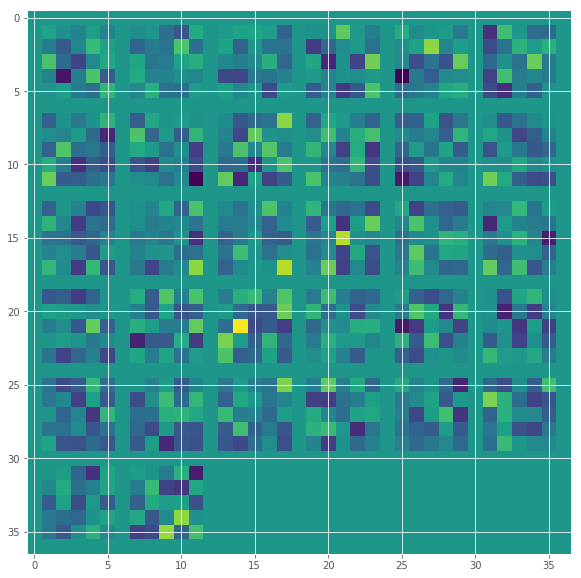

In [12]:
plt.imshow(utils.montage_filters(W1), interpolation='nearest');

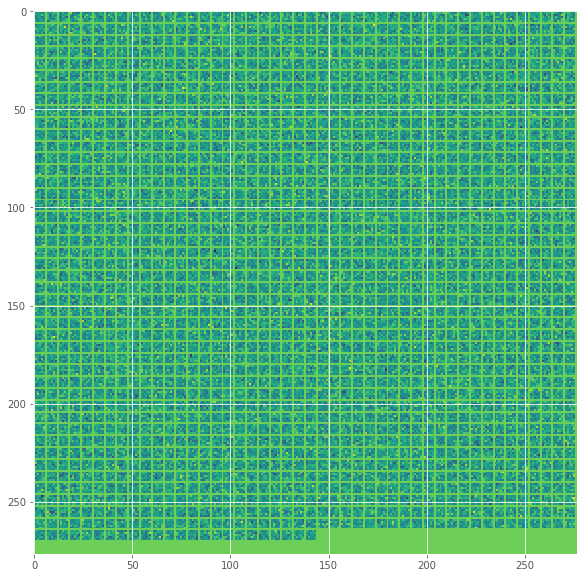

In [13]:
plt.imshow(utils.montage_filters(W2 / np.max(W2)));

## Saving/Loading Models

In [14]:
s = tf.Session()
init_op = tf.global_variables_initializer()
saver = tf.train.Saver()
s.run(init_op)

if os.path.exists('conv_classifier_model.ckpt'):
    saver.restore(s, 'conv_classifier_model.ckpt')
    print('Model restored.')

In [16]:
save_path = saver.save(s, 'conv_classifier_model.ckpt')
print('Model saved in file: %s' % save_path)

Model saved in file: conv_classifier_model.ckpt


### Protobuf
The second way of saving a model is really useful for when you don't want to pass around the code for producing the tensors or computational graph itself. It is also useful for moving the code to deployment or for use in the C++ version of Tensorflow. To do this, you'll want to run an operation to convert all of your trained parameters into constants. Then, you'll create a second graph which copies the necessary tensors, extracts the subgraph, and writes this to a model. The summarized code below shows you how you could use a checkpoint to restore your models parameters, and then export the saved model as a protobuf.

In [18]:
path='./'
ckpt_name = 'conv_classifier_model.ckpt'
fname = 'model.tfmodel'
dst_nodes = ['Y']
g_1 = tf.Graph()

with tf.Session(graph=g_1) as s:
    x = tf.placeholder(tf.float32, shape=(1, 224, 224, 3))

    # Replace this with some code that will create the tensorflow graph:
    net = create_network() # <- not a defined function here
    s.run(tf.global_variables_initializer())
    saver.restore(s, ckpt_name)
    graph_def = tf.python.graph_util.convert_variables_to_constants(
        s, s.graph_def, dst_nodes)

g_2 = tf.Graph()

with tf.Session(graph=g_2) as s:
    tf.train.write_graph(
        tf.python.graph_util.extract_sub_graph(
            graph_def, dst_nodes), path, fname, as_text=False)

NameError: name 'create_network' is not defined

In [ ]:
with open('model.tfmodel', mode='rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

tf.import_graph_def(net['graph_def'], name='model')